#### import libraries, get data

In [ ]:
!pip install fiftyone
!pip uninstall opencv-python-headless
!pip install opencv-python-headless==4.1.2.30
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import numpy as np
import imutils
import keras.backend as K
from google.colab import drive
drive.mount('/gdrive')
import fiftyone as fo
import fiftyone.zoo as foz

     |████████████████████████████████| 1.2 MB 30.6 MB/s 
     |████████████████████████████████| 79.9 MB 105 kB/s 
     |████████████████████████████████| 106 kB 73.4 MB/s 
     |████████████████████████████████| 55 kB 5.0 MB/s 
     |████████████████████████████████| 508 kB 72.6 MB/s 
     |████████████████████████████████| 29.2 MB 1.2 MB/s 
     |████████████████████████████████| 640 kB 70.3 MB/s 
     |████████████████████████████████| 564 kB 42.5 MB/s 
     |████████████████████████████████| 47.7 MB 1.8 MB/s 
     |████████████████████████████████| 131 kB 67.3 MB/s 
     |████████████████████████████████| 13.2 MB 53.7 MB/s 
     |████████████████████████████████| 226 kB 71.2 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 68 kB 8.2 MB/s 
     |████████████████████████████████| 54 kB 4.2 MB/s 
     |████████████████████████████████| 79 kB 10.9 MB/s 
     |████████████████████████████████| 77 kB 9.0 MB/s 
     |██████████████████

In [ ]:
dataset1 = foz.load_zoo_dataset(
    "open-images-v6",
    label_types = ['segmentations'],
    classes=['Cat'],
    max_samples=1000,
    overwrite=True,
    seed=24,
    shuffle=True,
    dataset_name = "meowmeowdata1"
)

Overwriting existing directory '/root/fiftyone/open-images-v6/validation'
 100% |██████|    4.8Gb/4.8Gb [3.7s elapsed, 0s remaining, 1.3Gb/s]         
 100% |█████████████████| 1000/1000 [53.4s elapsed, 0s remaining, 18.8 files/s]      
Only found 826 (<1000) samples matching your requirements
 100% |███████████████████| 826/826 [46.1s elapsed, 0s remaining, 17.4 files/s]      
Only found 271 (<1000) samples matching your requirements
 100% |███████████████████| 271/271 [12.9s elapsed, 0s remaining, 22.0 files/s]      
Dataset info written to '/root/fiftyone/open-images-v6/info.json'
Loading existing dataset 'meowmeowdata1'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


#### preprocessing

In [ ]:
dataset1.first()

<Sample: {
    'id': '61fcdc6846aff3227dc3788e',
    'media_type': 'image',
    'filepath': '/root/fiftyone/open-images-v6/validation/data/2e4831cdf0b4ce1e.jpg',
    'tags': BaseList(['validation']),
    'metadata': None,
    'segmentations': <Detections: {
        'detections': BaseList([
            <Detection: {
                'id': '61fcdc6846aff3227dc3788d',
                'attributes': BaseDict({}),
                'tags': BaseList([]),
                'label': 'Cat',
                'bounding_box': BaseList([0.0, 0.0, 1.0, 1.0]),
                'mask': array([[False, False, False, ..., False, False, False],
                       [False, False, False, ..., False, False, False],
                       [False, False, False, ..., False, False, False],
                       ...,
                       [False, False, False, ..., False, False, False],
                       [False, False, False, ..., False, False, False],
                       [False, False, False, ..., False, Fa

In [ ]:
img_data = []
img_mask = []
for data in dataset1:
    # get image, mask, bounding box from data
    img = cv2.imread(data['filepath'])
    mask = data['segmentations']['detections'][0]['mask']
    bounding_box = data['segmentations']['detections'][0]['bounding_box']

    # resize image to mask
    w = round(bounding_box[2] * img.shape[1])
    h = round(bounding_box[3] * img.shape[0])
    img = imutils.resize(img, width = round(mask.shape[1] / (bounding_box[2] * img.shape[1]) * img.shape[1] + 2))

    # cut image to bounding box
    x = int(bounding_box[0] * img.shape[1])
    y = int(bounding_box[1] * img.shape[0])
    img = img[y:y+mask.shape[0], x:x+mask.shape[1]].copy()

    # resize image and mask to SIZE
    SIZE = (256, 256)
    masked_img = img.copy()
    masked_img[~mask] = [0, 0, 0]
    masked_img = cv2.resize(masked_img, SIZE, interpolation=cv2.INTER_CUBIC)
    img = cv2.resize(img, SIZE, interpolation=cv2.INTER_CUBIC)
    mask = np.zeros((SIZE[0],SIZE[1],1), np.uint8)
    mask[np.nonzero(cv2.cvtColor(masked_img,cv2.COLOR_BGR2GRAY))] = 1

    # append image and mask to list
    img_data.append(img)
    img_mask.append(mask)

#### train

In [ ]:
!pip install segmentation_models

In [ ]:
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
x, x_val, y, y_val = train_test_split(np.array(img_data), np.array(img_mask), test_size=0.2, random_state=43)

# preprocess input
x = preprocess_input(x)
x_val = preprocess_input(x_val)
y = y.astype(np.float32)
y_val = y_val.astype(np.float32)

# define model
sm.set_framework('tf.keras')
sm.framework()
model = sm.Linknet(BACKBONE, encoder_weights='imagenet')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

# fit model
model.fit(
   x=x,
   y=y,
   batch_size=16,
   epochs=300,
   validation_data=(x_val, y_val),
)

Epoch 1/300
14/14 [==============================] - 12s 344ms/step - loss: 1.2184 - iou_score: 0.4471 - val_loss: 2.8209 - val_iou_score: 0.6376
Epoch 2/300
14/14 [==============================] - 3s 218ms/step - loss: 0.8934 - iou_score: 0.6000 - val_loss: 5.5907 - val_iou_score: 0.6344
Epoch 3/300
14/14 [==============================] - 3s 206ms/step - loss: 0.6750 - iou_score: 0.6969 - val_loss: 1.2782 - val_iou_score: 0.6222
Epoch 4/300
14/14 [==============================] - 3s 208ms/step - loss: 0.5297 - iou_score: 0.7622 - val_loss: 1.4250 - val_iou_score: 0.5015
Epoch 5/300
14/14 [==============================] - 3s 199ms/step - loss: 0.5034 - iou_score: 0.7859 - val_loss: 1.1400 - val_iou_score: 0.6375
Epoch 6/300
14/14 [==============================] - 3s 208ms/step - loss: 0.4951 - iou_score: 0.7950 - val_loss: 1.1400 - val_iou_score: 0.6931
Epoch 7/300
14/14 [==============================] - 3s 208ms/step - loss: 0.3977 - iou_score: 0.8247 - val_loss: 1.4381 - val_io

KeyboardInterrupt: ignored

#### visualize result

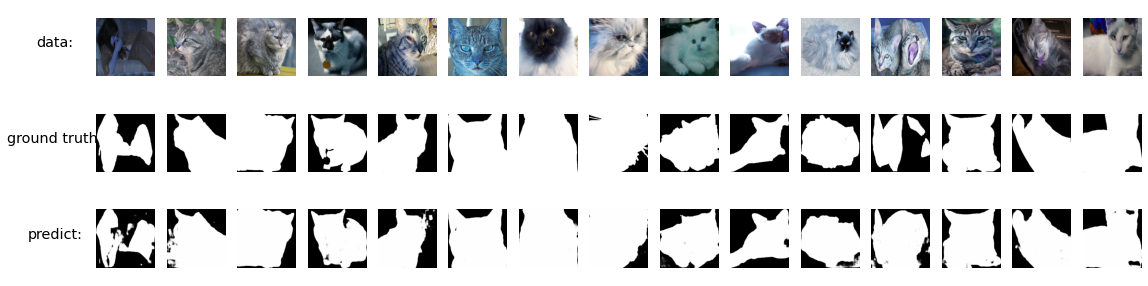

In [ ]:
NUM_DATA = 15
random_sample = np.random.choice(range(len(x_val)), NUM_DATA, replace=False)
f, axarr = plt.subplots(3, NUM_DATA + 1, figsize=(20,5))
label = ['data:', 'ground truth:', 'predict:']
for i in range(3):
    axarr[i][0].axis('off')
    axarr[i][0].text(0.5, 0.5, label[i], fontsize='x-large', ha='center')
for ind, i in enumerate(random_sample):
    axarr[0][ind + 1].axis('off')
    axarr[0][ind + 1].imshow(x_val[i])
for ind, i in enumerate(random_sample):
    axarr[1][ind + 1].axis('off')
    axarr[1][ind + 1].imshow(cv2.merge([y_val[i], y_val[i], y_val[i]]))
for ind, i in enumerate(random_sample):
    mask = model.predict(np.array([x_val[i]]))[0]
    axarr[2][ind + 1].axis('off')
    axarr[2][ind + 1].imshow(cv2.merge([mask, mask, mask]))


In [ ]:
model.save_weights('/gdrive/MyDrive/model_weight.h5')